# Basic CNN based digit recognizer 

In this tutorial we shall go through a bangla digit recognizer model in details. Our model is going to be based on a convolutional neural network (CNN). The focus is to get familiar with the components of a bangla digit recognizer framework. There are three steps in building this digit recognizer, <br>
**Step 1 : Process the data.<br>
Step 2 : Design the model.<br>
Step 3 : Train the model.**

In [20]:
# Importing necessary libraries
import numpy as np
import os
import glob
import cv2
import matplotlib.pyplot as plt
import pandas as pd
import pickle
from keras.utils import to_categorical
from keras.layers import Dense, Input, Conv2D, Flatten, MaxPool2D, Activation
from keras.models import Model
from keras.callbacks import ModelCheckpoint
from keras import backend as K

While writing the codes, files and folder was organized in the following way     
* Numta
   * code
   * data
   * model
   * Final_DB 
      
The `code` folder contains this jupyter notebook, the processed images will be placed in the `data` folder, the trained model will be saved in the `model` folder, and the `Final_DB` folder has the raw image datasets.

## Step 1: Process the data

Our dataset comes from six different source. For this tutorial we are using only dataset **A**.

In [11]:
#Declaring constants
FIG_WIDTH=16 # Width of figure
ROW_HEIGHT=3 # Height of each row when showing a figure which consists of multiple rows
RESIZE_DIM=28 # The images will be resized to 28x28 pixels

In [5]:
project_dir='..' 
# We hall get all the filepaths by using glob.glob() function 
paths_train_a=glob.glob(os.path.join(project_dir,'Final_DB','training-a','*.png'))
paths_test_a=glob.glob(os.path.join(project_dir,'Final_DB','testing-a','*.png'))
path_label_train_a=os.path.join(project_dir,'Final_DB','training-a.csv')
path_label_test_a=os.path.join(project_dir,'Final_DB','testing-a.csv')

### Define some utility functions

We shall write some helper functions to process and visualize the images.

In [24]:
def get_key(path):
    # seperates the key of an image from the filepath
    key=path.split(sep=os.sep)[-1]
    return key

def get_data(paths_img,path_label,resize_dim=None,rescale=True):
    '''reads images from the filepaths, resizes them, and returns them in a numpy array
    Args:
        paths_img: image filepaths
        path_label: image label filepath
    Returns:
        X: group of images
        y: categorical true labels
    '''
    X=[] # initialize empty list for resized images
    for i,path in enumerate(paths_img):
        img=cv2.imread(path,cv2.IMREAD_GRAYSCALE) # read image, image size is 180x180
        if resize_dim!=None:
            img=cv2.resize(img,(resize_dim,resize_dim),interpolation=cv2.INTER_AREA) # resize image to 28x28
        if rescale==True:
            img=img/255
        X.append(np.expand_dims(img,axis=2)) # expand image to 28x28x1 and append to the list.
        # display progress
        if i==len(paths_img)-1:
            end='\n'
        else: end='\r'
        print('processed {}/{}'.format(i+1,len(paths_img)),end=end)
        
    X=np.array(X) # tranform list to numpy array
    df = pd.read_csv(path_label) # read labels
    df=df.set_index('filename') 
    y_label=[df.loc[get_key(path)]['digit'] for path in  paths_img] # get the labels corresponding to the images
    y=to_categorical(y_label,10) # transfrom integer value to categorical variable
    return X, y

def imshow_group(X,y=None,y_pred=None,n_per_row=10,phase='processed'):
    '''helper function to visualize a group of images along with their categorical true labels (y).
    Args:
        X: group of images
        y: categorical true labels
        y_pred: predicted class probabilities
        n_per_row: number of images per row to be plotted
    '''
    n_sample=len(X)
    img_dim=X.shape[1]
    j=np.ceil(n_sample/n_per_row)
    fig=plt.figure(figsize=(FIG_WIDTH,HEIGHT_PER_ROW*j))
    for i,img in enumerate(X):
        plt.subplot(j,n_per_row,i+1)
        img_sq=np.squeeze(img,axis=2)
        plt.imshow(img_sq,cmap='gray')
        if y is not None:
            plt.title(np.argmax(y[i]))
        if y_pred is not None:
            top_n=3 # top 3 predictions with highest probabilities
            ind_sorted=np.argsort(y_pred[i])[::-1]
            h=img_dim+4
            for k in range(top_n):
                string='pred: {} ({:.0f}%)\n'.format(ind_sorted[k],y_pred[i,ind_sorted[k]]*100)
                plt.text(img_dim/2, h, string, horizontalalignment='center',verticalalignment='center')
                h+=4
        plt.axis('off')
    plt.show()

Next we are going to use the `get_data()` function to process all the images from dataset **A**

In [25]:
X_train_a,y_train_a=get_data(paths_train_a,path_label_train_a,resize_dim=RESIZE_DIM)
X_test_a,y_test_a=get_data(paths_test_a,path_label_test_a,resize_dim=RESIZE_DIM)

processed 19702/19702
processed 3489/3489


Let's see some samples of the processed data.

In [26]:
X_sample=X_train_a[:40]
y_sample=y_train_a[:40]

In [27]:
X_sample.shape

(40, 28, 28, 1)

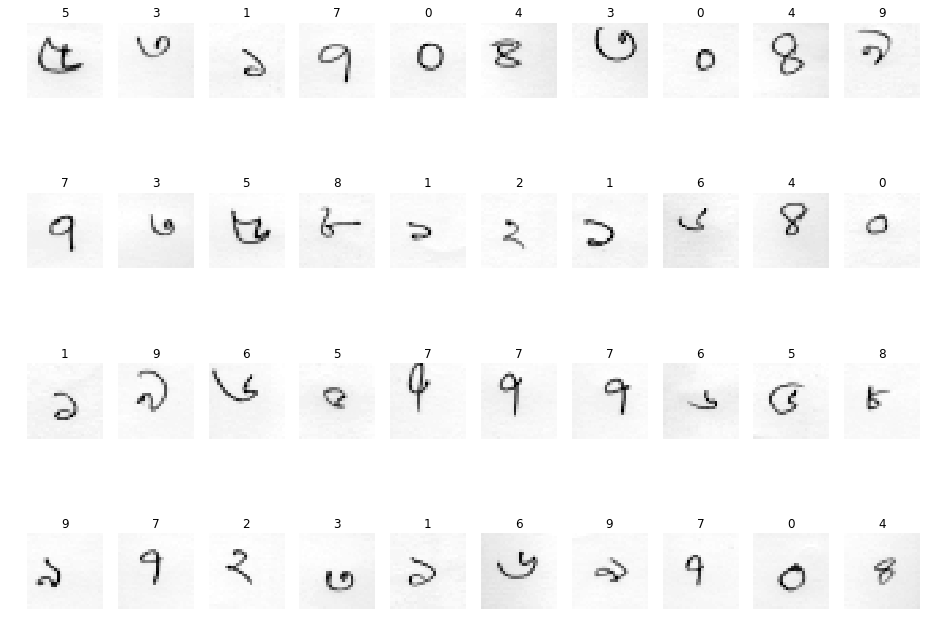

In [28]:
imshow_group(X=X_sample,y=y_sample)

Next, we are going to randomly choose 80% of the training data and use it to train our neural network. The remaining 20% images are going to be our validation data.

In [29]:
indices=list(range(len(X_train_a)))
np.random.shuffle(indices)

ind=int(len(indices)*0.80)

X_train=X_train_a[indices[:ind]] # train data
y_train=y_train_a[indices[:ind]]

X_val=X_train_a[indices[-(len(indices)-ind):]] # validation data
y_val=y_train_a[indices[-(len(indices)-ind):]]

## Step 2: Design the model

In this step we shall design our neural network model. We are going to build a small model based on the classic LeNet architecture. We shall use only three convolutional layers. Each convolution layer has rectified linear unit (ReLU) activation which is followed by a max pooling layer. The convolution layers are followed by two dense layers. 

In [30]:
def get_model():
    input_layer=Input(shape=(RESIZE_DIM,RESIZE_DIM,1))
    x=Conv2D(filters=8,kernel_size=(5,5),padding='valid', activation='relu')(input_layer)
    x=MaxPool2D(pool_size=(2,2),strides=2,padding='valid')(x)
    
    x=Conv2D(filters=16,kernel_size=(3,3),padding='valid', activation='relu')(x)
    x=MaxPool2D(pool_size=(2,2),strides=2,padding='valid')(x)
    
    x=Conv2D(filters=32,kernel_size=(3,3),padding='valid', activation='relu')(x)
    x=MaxPool2D(pool_size=(2,2),strides=2,padding='valid')(x)
    x=Flatten()(x)
    x=Dense(units=64)(x)
    x=Dense(units=10)(x)    
    output_layer=Activation('softmax')(x)
    model=Model(inputs=input_layer,outputs=output_layer)
    model.compile(loss='categorical_crossentropy',metrics=['accuracy'],optimizer='adam')
    return model
model=get_model()
model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_2 (InputLayer)         (None, 28, 28, 1)         0         
_________________________________________________________________
conv2d_4 (Conv2D)            (None, 24, 24, 8)         208       
_________________________________________________________________
max_pooling2d_4 (MaxPooling2 (None, 12, 12, 8)         0         
_________________________________________________________________
conv2d_5 (Conv2D)            (None, 10, 10, 16)        1168      
_________________________________________________________________
max_pooling2d_5 (MaxPooling2 (None, 5, 5, 16)          0         
_________________________________________________________________
conv2d_6 (Conv2D)            (None, 3, 3, 32)          4640      
_________________________________________________________________
max_pooling2d_6 (MaxPooling2 (None, 1, 1, 32)          0         
__________

## Step 3: Train the model

In [31]:
path_model=os.path.join(project_dir,'model','model_tutorial.h5') # save model at this location after each epoch
K.tensorflow_backend.clear_session() # destroys the current graph and builds a new one
model=get_model() # create the model
K.set_value(model.optimizer.lr,1e-3) # set the learning rate
# fit the model
h=model.fit(x=X_train,     
            y=y_train, 
            batch_size=512, 
            epochs=100, 
            verbose=1, 
            validation_data=(X_val,y_val),
            shuffle=True,
            callbacks=[
                ModelCheckpoint(filepath=path_model),
            ]
            )

Train on 15761 samples, validate on 3941 samples
Epoch 1/100
15761/15761 [==============================] - 11s - loss: 2.3011 - acc: 0.1112 - val_loss: 2.2956 - val_acc: 0.1601
Epoch 2/100
15761/15761 [==============================] - 10s - loss: 2.2691 - acc: 0.1958 - val_loss: 2.2111 - val_acc: 0.2492
Epoch 3/100
15761/15761 [==============================] - 9s - loss: 2.0735 - acc: 0.2851 - val_loss: 1.9051 - val_acc: 0.3618
Epoch 4/100
15761/15761 [==============================] - 8s - loss: 1.8011 - acc: 0.3850 - val_loss: 1.6601 - val_acc: 0.4552
Epoch 5/100
15761/15761 [==============================] - 8s - loss: 1.5588 - acc: 0.4707 - val_loss: 1.4277 - val_acc: 0.5306
Epoch 6/100
15761/15761 [==============================] - 9s - loss: 1.3297 - acc: 0.5518 - val_loss: 1.2350 - val_acc: 0.5851
Epoch 7/100
15761/15761 [==============================] - 9s - loss: 1.1561 - acc: 0.6118 - val_loss: 1.0730 - val_acc: 0.6468
Epoch 8/100
15761/15761 [============================

15761/15761 [==============================] - 9s - loss: 0.2776 - acc: 0.9143 - val_loss: 0.3137 - val_acc: 0.9005
Epoch 64/100
15761/15761 [==============================] - 9s - loss: 0.2662 - acc: 0.9168 - val_loss: 0.3168 - val_acc: 0.9010
Epoch 65/100
15761/15761 [==============================] - 8s - loss: 0.2559 - acc: 0.9206 - val_loss: 0.3190 - val_acc: 0.8993
Epoch 66/100
15761/15761 [==============================] - 10s - loss: 0.2534 - acc: 0.9221 - val_loss: 0.3033 - val_acc: 0.9033
Epoch 67/100
15761/15761 [==============================] - 9s - loss: 0.2433 - acc: 0.9256 - val_loss: 0.3087 - val_acc: 0.9008
Epoch 68/100
15761/15761 [==============================] - 9s - loss: 0.2434 - acc: 0.9258 - val_loss: 0.3092 - val_acc: 0.9033
Epoch 69/100
15761/15761 [==============================] - 8s - loss: 0.2447 - acc: 0.9253 - val_loss: 0.3176 - val_acc: 0.8950
Epoch 70/100
15761/15761 [==============================] - 9s - loss: 0.2438 - acc: 0.9256 - val_loss: 0.296

After 100 epochs training accuracy is 92% and valiadation accuracy is 90%. 

Let's evaluate the model performance on the test set

In [32]:
model.evaluate(X_test_a,y_test_a)

3489/3489 [==============================] - 1s     


[0.32883184219959577, 0.90083118372026372]

The loss and accuracy is similar to the validation set.

## Result Analysis

Let's observe the images which is misclassified by our model.

In [33]:
predictions=model.predict(X_test_a) # get predictions for all the test data

In [34]:
# get the indice of the images which were incorrectly labeled
incorrect_ind=[]
for i,pred in enumerate(predictions):
    if np.argmax(y_test_a[i])!=np.argmax(pred):
        incorrect_ind.append(i)

In [35]:
# let's observe some samples of the incorrect data
X_inc=X_test_a[incorrect_ind[:40]]
y_inc=predictions[incorrect_ind[:40]]
y_true=y_test_a[incorrect_ind[:40]]

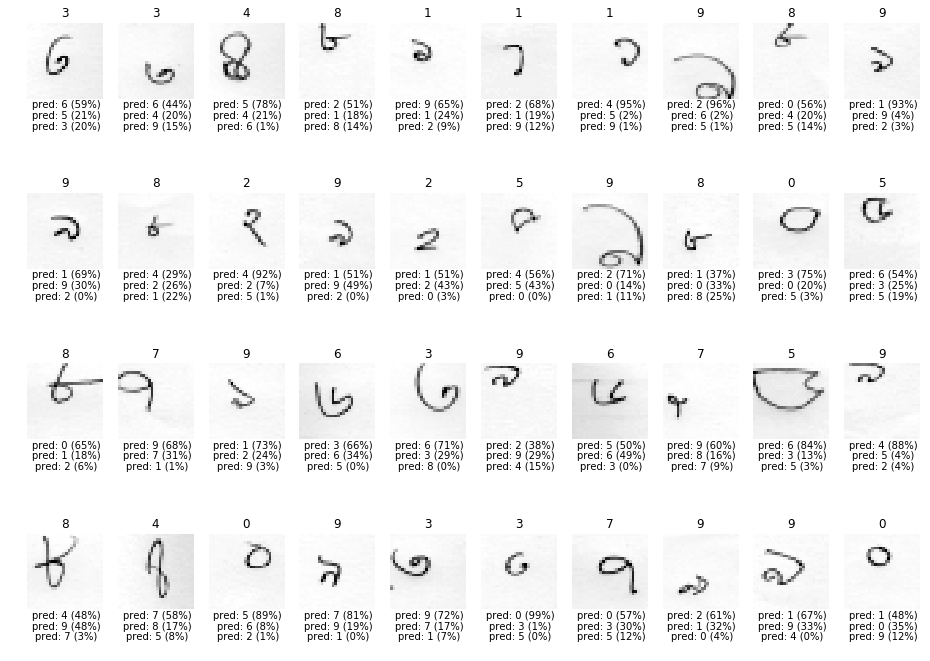

In [36]:
imshow_group(X=X_inc,y=y_true,y_pred=y_inc)

Our model misclassifies often misclassifies '5' as '6', '9' as '1', among other mistakes. Since the neural network architecture used in this tutorial is shallow, has a simple architecture and not fine-tuned for this problem, its performance is not quite satisfactory. A deeper state of the art architecture should yield better results which will be investigated in future notebooks.